#### Training with MNIST for all classes

In [1]:
import idx2numpy
X_train_3D = idx2numpy.convert_from_file('MNIST_dataset/train-images-idx3-ubyte')
X_train = X_train_3D.flatten().reshape(60000,784)

y_train = idx2numpy.convert_from_file('MNIST_dataset/train-labels-idx1-ubyte')
print(X_train.shape, y_train.shape)

X_test_3D = idx2numpy.convert_from_file('MNIST_dataset/t10k-images-idx3-ubyte')
X_test =  X_test_3D.flatten().reshape(10000,784)

y_test = idx2numpy.convert_from_file('MNIST_dataset/t10k-labels-idx1-ubyte')
print(X_test.shape, y_test.shape)

import numpy as np
from sklearn.utils import shuffle
X_shuffle,y_shuffle = shuffle(X_train,y_train)
X_train = X_shuffle[0:50000]
y_train = y_shuffle[0:50000]

from sklearn import tree
from sklearn.model_selection import cross_val_predict

#dt_clf = tree.DecisionTreeClassifier(max_depth=20, max_leaf_nodes=300)
#dt_clf = tree.DecisionTreeClassifier(max_depth=4, max_leaf_nodes=20)
dt_clf = tree.DecisionTreeClassifier(max_depth=8)

#y_train_pred = cross_val_predict(dt_clf, X_train, y_train, cv=2)
print(dt_clf.fit(X_train, y_train))

print('Number of nodes in the decision tree {}.'.format(dt_clf.tree_.node_count))
print('Number of threshold in the decision tree {}.'.format(len(dt_clf.tree_.threshold)))
print('Number of leaves in the decision tree {}.'.format(dt_clf.tree_.n_leaves))

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, dt_clf.predict(X_test)), accuracy_score(y_train, dt_clf.predict(X_train)))

(60000, 784) (60000,)
(10000, 784) (10000,)
DecisionTreeClassifier(max_depth=8)
Number of nodes in the decision tree 493.
Number of threshold in the decision tree 493.
Number of leaves in the decision tree 247.
0.8206 0.8324


In [2]:
threshold = dt_clf.tree_.threshold
import pandas as pd
df_train = pd.DataFrame(data = X_train, columns = range(X_train[0].shape[0]))
df_test = pd.DataFrame(data = X_test, columns = range(X_test[0].shape[0]))
df_train.shape, df_test.shape
df = pd.concat([df_train, df_test])
unique_vals = []
for i in df.columns:
    unique_vals.append(df[i].unique())
flatten_list = np.concatenate(unique_vals).ravel()
print('Max and Min values of thresholds in decision tree are', max([int(i) for i in list(set(threshold))]), min([int(i) for i in list(set(threshold))]))

Max and Min values of thresholds in decision tree are 246 -2


#### Displaying the nodes/leaves that were visited for training each class. Also display which are the intermeduate nodes and which are the leaves.

In [3]:
# Get the paths to the leaf nodes for each class
clf = dt_clf
leaf_paths = {}
for class_label in np.unique(y_train):
    leaf_paths[class_label] = clf.decision_path(X_train[y_train == class_label])

# Group the leaf nodes for each class
class_groups = {}
for class_label, paths in leaf_paths.items():
    group = {'leaves': set(), 'intermediate': set()}
    for path in paths:
        # Get the indices of the nodes in the path
        node_indices = np.where(path.toarray().flatten())[0]
        # Identify leaf nodes and intermediate nodes
        for idx in node_indices:
            node = clf.tree_.value[idx].argmax()
            if clf.tree_.children_left[idx] == -1 and clf.tree_.children_right[idx] == -1:
                # Verify leaf node belongs to the current class
                if node == class_label:
                    group['leaves'].add(idx)
            else:
                group['intermediate'].add(idx)
    class_groups[class_label] = group

# Verify leaf nodes don't belong to other classes
for class_label, groups in class_groups.items():
    for other_class_label, other_groups in class_groups.items():
        if other_class_label != class_label:
            intersection = groups['leaves'].intersection(other_groups['leaves'])
            if intersection:
                print(f"Warning: Leaf nodes for class {class_label} intersect with class {other_class_label}: {intersection}")

leaf_nodes_per_class = {}
intermediate_nodes_per_class = {}
# Print the groups
for class_label, groups in class_groups.items():
    print(f"Class {class_label}:")
    print("Intermediate Nodes:", groups['intermediate'])
    intermediate_nodes_per_class[class_label] = groups['intermediate']
    print("Leaf Nodes:", groups['leaves'])
    leaf_nodes_per_class[class_label] = groups['leaves']

Class 0:
Intermediate Nodes: {0, 1, 2, 3, 4, 5, 6, 7, 10, 20, 21, 22, 25, 28, 29, 35, 36, 37, 38, 41, 44, 45, 48, 51, 52, 53, 56, 59, 60, 63, 66, 67, 68, 69, 70, 74, 75, 78, 81, 82, 83, 86, 89, 90, 93, 96, 97, 98, 102, 105, 109, 112, 113, 114, 117, 120, 121, 124, 127, 128, 129, 130, 131, 132, 135, 138, 142, 145, 146, 147, 153, 154, 157, 160, 176, 177, 178, 184, 185, 188, 191, 192, 193, 201, 202, 205, 208, 209, 210, 213, 216, 217, 220, 223, 224, 225, 229, 232, 233, 236, 239, 240, 241, 244, 247, 248, 251, 254, 255, 256, 257, 258, 259, 260, 263, 273, 274, 275, 278, 281, 282, 285, 288, 289, 290, 291, 294, 297, 301, 304, 305, 309, 312, 313, 316, 319, 320, 321, 322, 326, 329, 330, 333, 336, 344, 345, 348, 351, 352, 360, 361, 364, 367, 368, 369, 372, 375, 376, 379, 382, 383, 415, 416, 417, 418, 424, 428, 431, 439, 440, 446, 447, 448, 456, 457, 460, 463, 464, 465, 471, 472, 475, 478, 479, 487, 488, 494, 495, 496, 499, 502, 503, 506}
Leaf Nodes: {12, 24, 30, 43, 314, 58, 61, 65, 71, 335, 79, 80

##### Sanity checks that there is no sharing of leaves between classes.

In [4]:
for i in intermediate_nodes_per_class.keys():
    for j in leaf_nodes_per_class.keys():
        if i!=j:
            intersection = leaf_nodes_per_class[i].intersection(leaf_nodes_per_class[j])
            if intersection:
                print(f'Warning: The leaf nodes between class {i} and {j} has common leaves: {intersection}.')
    

#### Creating a set containing intermediate nodes and leafs.

In [5]:
intermediate_nodes = set()
leaf_nodes = set()
for i in intermediate_nodes_per_class.keys():
    intermediate_nodes.update(intermediate_nodes_per_class[i])
    
for j in leaf_nodes_per_class.keys():
    leaf_nodes.update(leaf_nodes_per_class[j])

##### Check the nodes that were used in forget class but not in other classes.

In [6]:
forget_class = 9
segregated_nodes = intermediate_nodes_per_class[forget_class] - intermediate_nodes
print(segregated_nodes)

set()


#### Nodes removal

Accuracy before unlearning: 0.8157


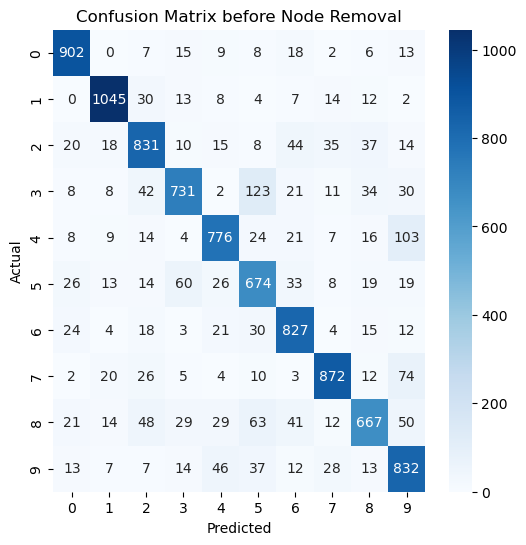

Accuracy after unlearning for class 9 : 0.8157


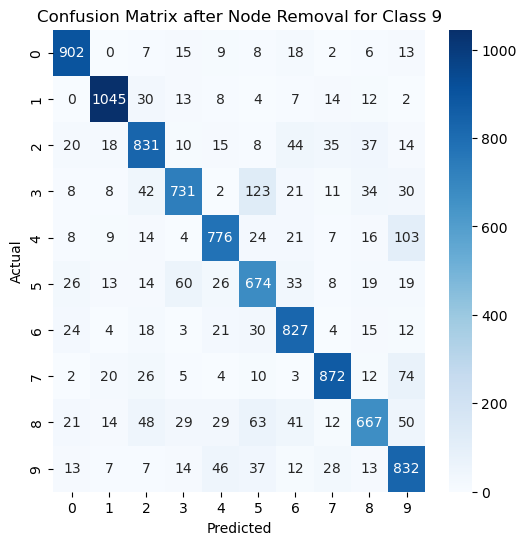

In [7]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def remove_nodes_for_class(tree, class_label_to_unlearn, X_train, y_train):
    """
    Prune nodes associated with a specific class label from a decision tree.

    Parameters:
    - tree: DecisionTreeClassifier object representing the decision tree model.
    - class_label_to_unlearn: Label of the class for which nodes need to be pruned.
    - X_train: Training features.
    - y_train: Training labels.

    Returns:
    - pruned_tree: New DecisionTreeClassifier object with nodes associated with the specified class pruned.
    """

    # Initialize a new decision tree classifier
    pruned_tree = DecisionTreeClassifier(random_state=42)

    # Copy the structure of the original tree
    pruned_tree = tree.__class__()
    pruned_tree.__dict__ = tree.__dict__.copy()

    # Find instances of the specified class label in the training data
    class_indices = np.where(y_train == class_label_to_unlearn)[0]

    # Find the indices of nodes associated with the specified class label
    nodes_to_prune = []
    for idx in class_indices:
        node_index = tree.apply(X_train[idx:idx+1])[0]
        if tree.tree_.value[node_index].argmax() == class_label_to_unlearn:
            nodes_to_prune.append(node_index)

    # Prune the identified nodes
    for node_index in nodes_to_prune:
        pruned_tree.tree_.children_left[node_index] = -1
        pruned_tree.tree_.children_right[node_index] = -1

    return pruned_tree

# Train a decision tree classifier on the training data
tree_classifier = DecisionTreeClassifier(random_state=42, max_depth=8)
tree_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = tree_classifier.predict(X_test)

# Calculate accuracy before unlearning
accuracy_before_unlearning = accuracy_score(y_test, y_pred)
print("Accuracy before unlearning:", accuracy_before_unlearning)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix before Node Removal')
plt.show()


# Specify the class label for unlearning (e.g., class 9 for digit 9 in MNIST)
class_label_to_remove = 9

# Remove nodes associated with the specified class label
pruned_tree = remove_nodes_for_class(tree_classifier, class_label_to_remove, X_train, y_train)

# Make predictions on the testing set using the pruned tree
y_pred_pruned = pruned_tree.predict(X_test)

# Calculate accuracy after unlearning
accuracy_after_unlearning = accuracy_score(y_test, y_pred_pruned)
print("Accuracy after unlearning for class", class_label_to_remove, ":", accuracy_after_unlearning)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_pruned)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix after Node Removal for Class {}'.format(class_label_to_remove))
plt.show()


This is not forgetting as the accuracy drop is minimal and it is across all the classes, not only in `forget class` (this case it is 9).

# Extracting the decision rules with different mechanism: `chain` of `if` statements

In [4]:
%%capture cap --no-stderr

from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += ":\n"
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"    label_class= {class_names[l]} #(proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += ['  ' + rule]
        
    return rules

cols = range(784)
features = [f'feature_num[{i}]' for i in cols]
class_names = [str(i) for i in dt_clf.classes_]
tree_ = dt_clf.tree_
feature_name = [
    features[i] if i != _tree.TREE_UNDEFINED else "undefined!"
    for i in tree_.feature
]
print ("def decision_tree_inference({}):".format('feature_num'))
print('  label_class= None')
            
rules = get_rules(dt_clf, features, class_names)
for r in rules:
    print(r)
print('  return label_class')
    
with open('mnist_decision_tree_inference.py', 'w') as f:
    f.write(cap.stdout)

In [5]:
from mnist_decision_tree_inference import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
    
y_train_pred_tree = []
for i,test_samples in enumerate(X_train):
    y_train_pred_tree.append(decision_tree_inference(test_samples))
    
for i in range(len(y_train_pred_tree)):
    if y_train_pred_tree[i] is None:
        y_train_pred_tree[i] = 0

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_test_pred_tree), accuracy_score(y_train, y_train_pred_tree))

0.8206 0.8324


#### Verifying that the number of 'if' statements is equal to the number of leaves.

In [6]:
with open('mnist_decision_tree_inference.py', 'r') as f:
    rules = f.readlines()

counter_if = 0
for rule in rules:
    if 'if' in rule:
        counter_if = counter_if+1
print(counter_if)

247


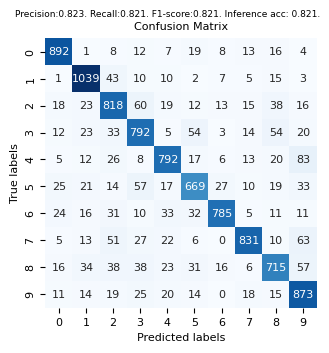

Precision: 0.8228864693927508
Recall: 0.8206
F1 Score: 0.8206211291737611
True Positives for Each Class: [ 892 1039  818  792  792  669  785  831  715  873]
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       980
           1       0.87      0.92      0.89      1135
           2       0.76      0.79      0.77      1032
           3       0.76      0.78      0.77      1010
           4       0.84      0.81      0.82       982
           5       0.78      0.75      0.77       892
           6       0.91      0.82      0.86       958
           7       0.89      0.81      0.85      1028
           8       0.78      0.73      0.76       974
           9       0.75      0.87      0.80      1009

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred_tree)

from sklearn.metrics import classification_report, precision_recall_fscore_support
# Extract precision, recall, and f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred_tree, average='weighted')
# Plot confusion matrix
plt.figure(figsize=(3.5, 3.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), 
            yticklabels=range(10), annot_kws={"size": 8}, cbar=False )
plt.xlabel('Predicted labels', fontsize=8)
plt.ylabel('True labels', fontsize=8)
plt.title('Confusion Matrix', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.text(4.5, -0.8, f"Precision:{round(precision,3)}. Recall:{round(recall,3)}. F1-score:{round(f1_score,3)}. Inference acc: {round(accuracy_score(y_test, y_test_pred_tree), 3)}.",
         horizontalalignment="center", fontsize=6.5)
plt.savefig('confusion_matrix_mnist.pdf')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)

##### Forgetting class 9.   

Unlearning time: 0.006407499313354492 seconds
0.7369
Inference time per sample after unlearn: 0.0005220145463943482 seconds


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


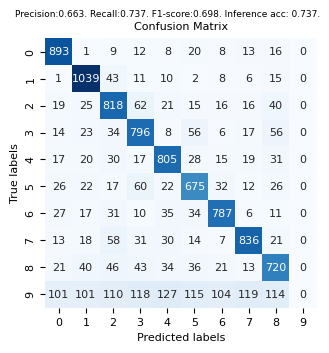

Precision: 0.6630615447290689
Recall: 0.7369
F1 Score: 0.6977127268416958
True Positives for Each Class: [ 893 1039  818  796  805  675  787  836  720    0]
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       980
           1       0.80      0.92      0.85      1135
           2       0.68      0.79      0.73      1032
           3       0.69      0.79      0.73      1010
           4       0.73      0.82      0.77       982
           5       0.68      0.76      0.72       892
           6       0.78      0.82      0.80       958
           7       0.79      0.81      0.80      1028
           8       0.69      0.74      0.71       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.74     10000
   macro avg       0.66      0.74      0.70     10000
weighted avg       0.66      0.74      0.70     10000

[16]


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [10]:
import time
start_time = time.time()

forget_class = 9
with open('mnist_decision_tree_inference.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()

node_removal=[]
node_removal_counter = 0
for idx,line in enumerate(tree_ifel_code):
    if f'label_class= {forget_class}' in line:
        tree_ifel_code[idx] = ''
        tree_ifel_code[idx-1] = ''
        node_removal_counter = node_removal_counter+1
node_removal.append(node_removal_counter)
        
        

with open('forget_9_mnistdt.py', 'w') as f:
    f.writelines(tree_ifel_code)
    f.close()

end_time = time.time()
execution_time = end_time - start_time
print("Unlearning time:", execution_time, "seconds")

start_time = time.time()
from forget_9_mnistdt import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = np.random.randint(0,forget_class)
        
print(accuracy_score(y_test, y_test_pred_tree))

end_time = time.time()

execution_time = end_time - start_time
print("Inference time per sample after unlearn:", execution_time/len(X_test), "seconds")

cm = confusion_matrix(y_test, y_test_pred_tree)

from sklearn.metrics import classification_report, precision_recall_fscore_support
# Extract precision, recall, and f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred_tree, average='weighted')
# Plot confusion matrix
plt.figure(figsize=(3.5, 3.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), 
            yticklabels=range(10), annot_kws={"size": 8}, cbar=False )
plt.xlabel('Predicted labels', fontsize=8)
plt.ylabel('True labels', fontsize=8)
plt.title('Confusion Matrix', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.text(4.5, -0.8, f"Precision:{round(precision,3)}. Recall:{round(recall,3)}. F1-score:{round(f1_score,3)}. Inference acc: {round(accuracy_score(y_test, y_test_pred_tree), 3)}.",
         horizontalalignment="center", fontsize=6.5)
plt.savefig(f'confusion_matrix_forget_{forget_class}.pdf')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)
print(node_removal)

#### Relearning method: from class 0 to 8.

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
start_time = time.time()

# Filter training and test data for classes 0 to 8
X_train_filtered = X_train[y_train <forget_class]
y_train_filtered = y_train[y_train <forget_class]
X_test_filtered = X_test[y_test <forget_class]
y_test_filtered = y_test[y_test <forget_class]

# Create Decision Tree Classifier
retrain_clf = DecisionTreeClassifier(max_depth=8)

# Train the classifier
retrain_clf.fit(X_train_filtered, y_train_filtered)

end_time = time.time()
execution_time = end_time - start_time
print("Re-learning time:", execution_time, "seconds")

# Predict on the test set
y_pred = retrain_clf.predict(X_test_filtered)

# Calculate accuracy score
accuracy = accuracy_score(y_test_filtered, y_pred)
print("Accuracy:", accuracy)

Re-learning time: 4.547188758850098 seconds
Accuracy: 0.8547436325214103


##### Run this cell twice.

In [14]:
%%capture cap --no-stderr

from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += ":\n"
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"    label_class= {class_names[l]} #(proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += ['  ' + rule]
        
    return rules

cols = range(784)
features = [f'feature_num[{i}]' for i in cols]
class_names = [str(i) for i in dt_clf.classes_]
tree_ = retrain_clf.tree_
feature_name = [
    features[i] if i != _tree.TREE_UNDEFINED else "undefined!"
    for i in tree_.feature
]
print ("def decision_tree_inference({}):".format('feature_num'))
print('  label_class= None')
            
rules = get_rules(retrain_clf, features, class_names)
for r in rules:
    print(r)
print('  return label_class')
    
with open(f'relearn_without{forget_class}.py', 'w') as f:
    f.write(cap.stdout)

In [16]:
start_time = time.time()
from relearn_without9 import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = np.random.randint(0,forget_class)
        
print(accuracy_score(y_test, y_test_pred_tree))

end_time = time.time()

execution_time = end_time - start_time
print("Inference time per sample after relearn:", execution_time/len(X_test), "seconds")

0.7685
Inference time per sample after relearn: 0.0006104232549667358 seconds


#### Forgetting class 8

Unlearning time: 0.011110067367553711 seconds
0.6666
Inference per sample after unlearn: 0.0005150868892669678 seconds


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


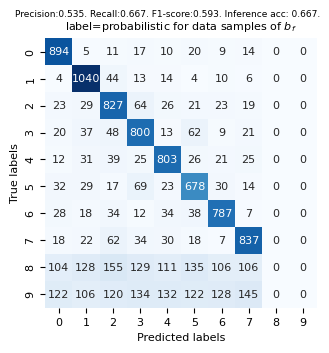

Precision: 0.5351007518964154
Recall: 0.6666
F1 Score: 0.5934026943973653
True Positives for Each Class: [ 894 1040  827  800  803  678  787  837    0    0]
              precision    recall  f1-score   support

           0       0.71      0.91      0.80       980
           1       0.72      0.92      0.81      1135
           2       0.61      0.80      0.69      1032
           3       0.62      0.79      0.69      1010
           4       0.67      0.82      0.74       982
           5       0.60      0.76      0.67       892
           6       0.70      0.82      0.75       958
           7       0.70      0.81      0.75      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.67     10000
   macro avg       0.53      0.66      0.59     10000
weighted avg       0.54      0.67      0.59     10000

[16, 24]


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [17]:
start_time = time.time()

forget_class = 8
with open('forget_9_mnistdt.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()
    
node_removal_counter = 0
for idx,line in enumerate(tree_ifel_code):
    if f'label_class= {forget_class}' in line:
        tree_ifel_code[idx] = ''
        tree_ifel_code[idx-1] = ''
        node_removal_counter = node_removal_counter+1
node_removal.append(node_removal_counter)
        

with open(f'forget_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(tree_ifel_code)
    f.close()


end_time = time.time()
execution_time = end_time - start_time
print("Unlearning time:", execution_time, "seconds")

start_time = time.time()
from forget_8_mnistdt import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))


import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = np.random.randint(0,forget_class)
        
print(accuracy_score(y_test, y_test_pred_tree))

end_time = time.time()

execution_time = end_time - start_time
print("Inference per sample after unlearn:", execution_time/len(X_test), "seconds")

cm = confusion_matrix(y_test, y_test_pred_tree)

from sklearn.metrics import classification_report, precision_recall_fscore_support
# Extract precision, recall, and f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred_tree, average='weighted')
# Plot confusion matrix
plt.figure(figsize=(3.5, 3.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), 
            yticklabels=range(10), annot_kws={"size": 8}, cbar=False )
plt.xlabel('Predicted labels', fontsize=8)
plt.ylabel('True labels', fontsize=8)
plt.title('label=probabilistic for data samples of $b_f$', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.text(4.5, -0.8, f"Precision:{round(precision,3)}. Recall:{round(recall,3)}. F1-score:{round(f1_score,3)}. Inference acc: {round(accuracy_score(y_test, y_test_pred_tree), 3)}.",
         horizontalalignment="center", fontsize=6.5)
plt.savefig(f'confusion_matrix_forget_{forget_class}.pdf')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)
print(node_removal)

#### Relearning method: from 0 to 7

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
start_time = time.time()

# Filter training and test data for classes 0 to 8
X_train_filtered = X_train[y_train <forget_class]
y_train_filtered = y_train[y_train <forget_class]
X_test_filtered = X_test[y_test <forget_class]
y_test_filtered = y_test[y_test <forget_class]

# Create Decision Tree Classifier
retrain_clf = DecisionTreeClassifier(max_depth=8)

# Train the classifier
retrain_clf.fit(X_train_filtered, y_train_filtered)

end_time = time.time()
execution_time = end_time - start_time
print("Re-learning time:", execution_time, "seconds")

# Predict on the test set
y_pred = retrain_clf.predict(X_test_filtered)

# Calculate accuracy score
accuracy = accuracy_score(y_test_filtered, y_pred)
print("Accuracy:", accuracy)

Re-learning time: 4.4325244426727295 seconds
Accuracy: 0.870774603966571


##### Run this cell twice.

In [20]:
%%capture cap --no-stderr

from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += ":\n"
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"    label_class= {class_names[l]} #(proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += ['  ' + rule]
        
    return rules

cols = range(784)
features = [f'feature_num[{i}]' for i in cols]
class_names = [str(i) for i in dt_clf.classes_]
tree_ = retrain_clf.tree_
feature_name = [
    features[i] if i != _tree.TREE_UNDEFINED else "undefined!"
    for i in tree_.feature
]
print ("def decision_tree_inference({}):".format('feature_num'))
print('  label_class= None')
            
rules = get_rules(retrain_clf, features, class_names)
for r in rules:
    print(r)
print('  return label_class')
    
with open(f'relearn_without{forget_class}.py', 'w') as f:
    f.write(cap.stdout)

In [21]:
start_time = time.time()
from relearn_without8 import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = np.random.randint(0,forget_class)
        
print(accuracy_score(y_test, y_test_pred_tree))

end_time = time.time()

execution_time = end_time - start_time
print("Inference time per sample after relearn:", execution_time/len(X_test), "seconds")

0.6981
Inference time per sample after relearn: 0.0004618274450302124 seconds


#### Adding extra class, class 10 for the forgetting of classes 8 and 9.

0.6656


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


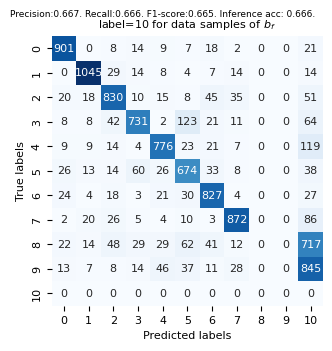

In [21]:
from forget_8_mnistdt import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))


for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 10
        
print(accuracy_score(y_test, y_test_pred_tree))

cm = confusion_matrix(y_test, y_test_pred_tree)

from sklearn.metrics import classification_report, precision_recall_fscore_support
# Extract precision, recall, and f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred_tree, average='weighted')
# Plot confusion matrix
plt.figure(figsize=(3.5, 3.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(11), 
            yticklabels=range(11), annot_kws={"size": 8}, cbar=False )
plt.xlabel('Predicted labels', fontsize=8)
plt.ylabel('True labels', fontsize=8)
plt.title('label=10 for data samples of $b_f$', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.text(4.5, -0.8, f"Precision:{round(precision,3)}. Recall:{round(recall,3)}. F1-score:{round(f1_score,3)}. Inference acc: {round(accuracy_score(y_test, y_test_pred_tree), 3)}.",
         horizontalalignment="center", fontsize=6.5)
plt.savefig(f'confusion_matrix_forget_10.pdf')
plt.show()

#### Forgetting class 7

Unlearning time: 0.003516674041748047 seconds
0.582
Inference per sample after unlearn: 0.0004279101610183716 seconds


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


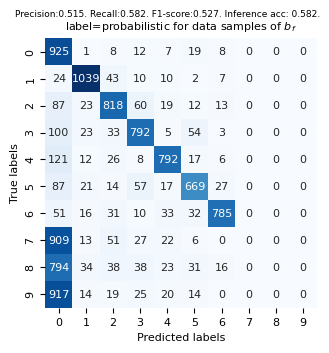

Precision: 0.5149540775654708
Recall: 0.582
F1 Score: 0.5268371726381347
True Positives for Each Class: [ 925 1039  818  792  792  669  785    0    0    0]
              precision    recall  f1-score   support

           0       0.23      0.94      0.37       980
           1       0.87      0.92      0.89      1135
           2       0.76      0.79      0.77      1032
           3       0.76      0.78      0.77      1010
           4       0.84      0.81      0.82       982
           5       0.78      0.75      0.77       892
           6       0.91      0.82      0.86       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.58     10000
   macro avg       0.51      0.58      0.53     10000
weighted avg       0.51      0.58      0.53     10000

[16, 24, 12]


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [22]:
start_time = time.time()

forget_class = 7
with open('forget_8_mnistdt.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()
    
node_removal_counter = 0
for idx,line in enumerate(tree_ifel_code):
    if f'label_class= {forget_class}' in line:
        tree_ifel_code[idx] = ''
        tree_ifel_code[idx-1] = ''
        node_removal_counter = node_removal_counter+1
node_removal.append(node_removal_counter)
        

with open(f'forget_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(tree_ifel_code)
    f.close()

end_time = time.time()
execution_time = end_time - start_time
print("Unlearning time:", execution_time, "seconds")

start_time = time.time()

from forget_7_mnistdt import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))


import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))


end_time = time.time()

execution_time = end_time - start_time
print("Inference per sample after unlearn:", execution_time/len(X_test), "seconds")

cm = confusion_matrix(y_test, y_test_pred_tree)

from sklearn.metrics import classification_report, precision_recall_fscore_support
# Extract precision, recall, and f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred_tree, average='weighted')
# Plot confusion matrix
plt.figure(figsize=(3.5, 3.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), 
            yticklabels=range(10), annot_kws={"size": 8}, cbar=False )
plt.xlabel('Predicted labels', fontsize=8)
plt.ylabel('True labels', fontsize=8)
plt.title('label=probabilistic for data samples of $b_f$', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.text(4.5, -0.8, f"Precision:{round(precision,3)}. Recall:{round(recall,3)}. F1-score:{round(f1_score,3)}. Inference acc: {round(accuracy_score(y_test, y_test_pred_tree), 3)}.",
         horizontalalignment="center", fontsize=6.5)
plt.savefig(f'confusion_matrix_forget_{forget_class}.pdf')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)
print(node_removal)

#### Relearning method: from class 0 to 6

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
start_time = time.time()

# Filter training and test data for classes 0 to 8
X_train_filtered = X_train[y_train <forget_class]
y_train_filtered = y_train[y_train <forget_class]
X_test_filtered = X_test[y_test <forget_class]
y_test_filtered = y_test[y_test <forget_class]

# Create Decision Tree Classifier
retrain_clf = DecisionTreeClassifier(max_depth=8)

# Train the classifier
retrain_clf.fit(X_train_filtered, y_train_filtered)

end_time = time.time()
execution_time = end_time - start_time
print("Re-learning time:", execution_time, "seconds")

# Predict on the test set
y_pred = retrain_clf.predict(X_test_filtered)

# Calculate accuracy score
accuracy = accuracy_score(y_test_filtered, y_pred)
print("Accuracy:", accuracy)

Re-learning time: 3.303570032119751 seconds
Accuracy: 0.8954070682501073


##### Run this cell twice.

In [24]:
%%capture cap --no-stderr

from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += ":\n"
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"    label_class= {class_names[l]} #(proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += ['  ' + rule]
        
    return rules

cols = range(784)
features = [f'feature_num[{i}]' for i in cols]
class_names = [str(i) for i in dt_clf.classes_]
tree_ = retrain_clf.tree_
feature_name = [
    features[i] if i != _tree.TREE_UNDEFINED else "undefined!"
    for i in tree_.feature
]
print ("def decision_tree_inference({}):".format('feature_num'))
print('  label_class= None')
            
rules = get_rules(retrain_clf, features, class_names)
for r in rules:
    print(r)
print('  return label_class')
    
with open(f'relearn_without{forget_class}.py', 'w') as f:
    f.write(cap.stdout)

In [25]:
start_time = time.time()
from relearn_without7 import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = np.random.randint(0,forget_class)
        
print(accuracy_score(y_test, y_test_pred_tree))

end_time = time.time()

execution_time = end_time - start_time
print("Inference time per sample after relearn:", execution_time/len(X_test), "seconds")

0.6981
Inference time per sample after relearn: 0.0004440887451171875 seconds


#### Forgetting class 6

Unlearning time: 0.002713441848754883 seconds
0.5043
Inference per sample after unlearn: 0.00030677356719970705 seconds


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


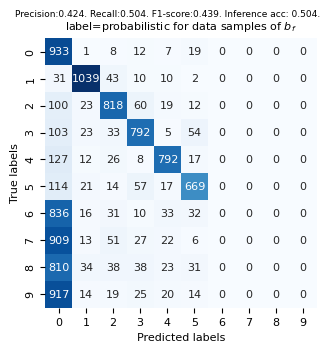

Precision: 0.42417283545646495
Recall: 0.5043
F1 Score: 0.439242357042555
True Positives for Each Class: [ 933 1039  818  792  792  669    0    0    0    0]
              precision    recall  f1-score   support

           0       0.19      0.95      0.32       980
           1       0.87      0.92      0.89      1135
           2       0.76      0.79      0.77      1032
           3       0.76      0.78      0.77      1010
           4       0.84      0.81      0.82       982
           5       0.78      0.75      0.77       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.50     10000
   macro avg       0.42      0.50      0.43     10000
weighted avg       0.42      0.50      0.44     10000

[16, 24, 12, 28]


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [26]:
start_time = time.time()
forget_class = 6
with open('forget_7_mnistdt.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()
    
node_removal_counter = 0
for idx,line in enumerate(tree_ifel_code):
    if f'label_class= {forget_class}' in line:
        tree_ifel_code[idx] = ''
        tree_ifel_code[idx-1] = ''
        node_removal_counter = node_removal_counter+1
node_removal.append(node_removal_counter)
        

with open(f'forget_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(tree_ifel_code)
    f.close()

end_time = time.time()
execution_time = end_time - start_time
print("Unlearning time:", execution_time, "seconds")

start_time = time.time()

from forget_6_mnistdt import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))


import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))

end_time = time.time()

execution_time = end_time - start_time
print("Inference per sample after unlearn:", execution_time/len(X_test), "seconds")

cm = confusion_matrix(y_test, y_test_pred_tree)

from sklearn.metrics import classification_report, precision_recall_fscore_support
# Extract precision, recall, and f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred_tree, average='weighted')
# Plot confusion matrix
plt.figure(figsize=(3.5, 3.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), 
            yticklabels=range(10), annot_kws={"size": 8}, cbar=False )
plt.xlabel('Predicted labels', fontsize=8)
plt.ylabel('True labels', fontsize=8)
plt.title('label=probabilistic for data samples of $b_f$', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.text(4.5, -0.8, f"Precision:{round(precision,3)}. Recall:{round(recall,3)}. F1-score:{round(f1_score,3)}. Inference acc: {round(accuracy_score(y_test, y_test_pred_tree), 3)}.",
         horizontalalignment="center", fontsize=6.5)
plt.savefig(f'confusion_matrix_forget_{forget_class}.pdf')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)
print(node_removal)

#### Retrain method: from class 0 to 5

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
start_time = time.time()

X_train_filtered = X_train[y_train <forget_class]
y_train_filtered = y_train[y_train <forget_class]
X_test_filtered = X_test[y_test <forget_class]
y_test_filtered = y_test[y_test <forget_class]

# Create Decision Tree Classifier
retrain_clf = DecisionTreeClassifier(max_depth=8)

# Train the classifier
retrain_clf.fit(X_train_filtered, y_train_filtered)

end_time = time.time()
execution_time = end_time - start_time
print("Re-learning time:", execution_time, "seconds")

# Predict on the test set
y_pred = retrain_clf.predict(X_test_filtered)

# Calculate accuracy score
accuracy = accuracy_score(y_test_filtered, y_pred)
print("Accuracy:", accuracy)

Re-learning time: 2.9721641540527344 seconds
Accuracy: 0.9141104294478528


##### Run this cell twice.

In [29]:
%%capture cap --no-stderr

from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += ":\n"
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"    label_class= {class_names[l]} #(proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += ['  ' + rule]
        
    return rules

cols = range(784)
features = [f'feature_num[{i}]' for i in cols]
class_names = [str(i) for i in dt_clf.classes_]
tree_ = retrain_clf.tree_
feature_name = [
    features[i] if i != _tree.TREE_UNDEFINED else "undefined!"
    for i in tree_.feature
]
print ("def decision_tree_inference({}):".format('feature_num'))
print('  label_class= None')
            
rules = get_rules(retrain_clf, features, class_names)
for r in rules:
    print(r)
print('  return label_class')
    
with open(f'relearn_without{forget_class}.py', 'w') as f:
    f.write(cap.stdout)

In [30]:
start_time = time.time()
from relearn_without6 import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = np.random.randint(0,forget_class)
        
print(accuracy_score(y_test, y_test_pred_tree))

end_time = time.time()

execution_time = end_time - start_time
print("Inference time per sample after relearn:", execution_time/len(X_test), "seconds")

0.5513
Inference time per sample after relearn: 0.00046576712131500244 seconds


#### Forgetting class 5

Unlearning time: 0.004313468933105469 seconds
0.4393
Inference per sample after unlearn: 0.00023618378639221193 seconds


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


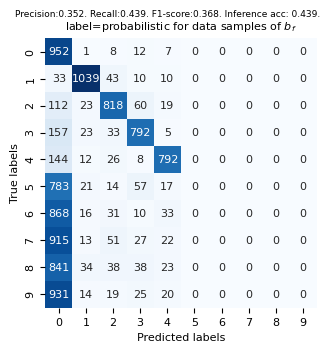

Precision: 0.35198780167125904
Recall: 0.4393
F1 Score: 0.3675416147824505
True Positives for Each Class: [ 952 1039  818  792  792    0    0    0    0    0]
              precision    recall  f1-score   support

           0       0.17      0.97      0.28       980
           1       0.87      0.92      0.89      1135
           2       0.76      0.79      0.77      1032
           3       0.76      0.78      0.77      1010
           4       0.84      0.81      0.82       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.44     10000
   macro avg       0.34      0.43      0.35     10000
weighted avg       0.35      0.44      0.37     10000

[16, 24, 12, 28, 37, 37]


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [36]:
start_time = time.time()

forget_class = 5
with open('forget_6_mnistdt.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()
    
node_removal_counter = 0
for idx,line in enumerate(tree_ifel_code):
    if f'label_class= {forget_class}' in line:
        tree_ifel_code[idx] = ''
        tree_ifel_code[idx-1] = ''
        node_removal_counter = node_removal_counter+1
node_removal.append(node_removal_counter)
        

with open(f'forget_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(tree_ifel_code)
    f.close()

end_time = time.time()
execution_time = end_time - start_time
print("Unlearning time:", execution_time, "seconds")

start_time = time.time()
from forget_5_mnistdt import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))


import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))

end_time = time.time()

execution_time = end_time - start_time
print("Inference per sample after unlearn:", execution_time/len(X_test), "seconds")

cm = confusion_matrix(y_test, y_test_pred_tree)

from sklearn.metrics import classification_report, precision_recall_fscore_support
# Extract precision, recall, and f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred_tree, average='weighted')
# Plot confusion matrix
plt.figure(figsize=(3.5, 3.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), 
            yticklabels=range(10), annot_kws={"size": 8}, cbar=False )
plt.xlabel('Predicted labels', fontsize=8)
plt.ylabel('True labels', fontsize=8)
plt.title('label=probabilistic for data samples of $b_f$', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.text(4.5, -0.8, f"Precision:{round(precision,3)}. Recall:{round(recall,3)}. F1-score:{round(f1_score,3)}. Inference acc: {round(accuracy_score(y_test, y_test_pred_tree), 3)}.",
         horizontalalignment="center", fontsize=6.5)
plt.savefig(f'confusion_matrix_forget_{forget_class}.pdf')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)
print(node_removal)

#### Relearn method: from class 0 to 4

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
start_time = time.time()

X_train_filtered = X_train[y_train <forget_class]
y_train_filtered = y_train[y_train <forget_class]
X_test_filtered = X_test[y_test <forget_class]
y_test_filtered = y_test[y_test <forget_class]

# Create Decision Tree Classifier
retrain_clf = DecisionTreeClassifier(max_depth=8)

# Train the classifier
retrain_clf.fit(X_train_filtered, y_train_filtered)

end_time = time.time()
execution_time = end_time - start_time
print("Re-learning time:", execution_time, "seconds")

# Predict on the test set
y_pred = retrain_clf.predict(X_test_filtered)

# Calculate accuracy score
accuracy = accuracy_score(y_test_filtered, y_pred)
print("Accuracy:", accuracy)

Re-learning time: 2.715381145477295 seconds
Accuracy: 0.9369527145359019


##### Run this cell twice.

In [34]:
%%capture cap --no-stderr

from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += ":\n"
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"    label_class= {class_names[l]} #(proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += ['  ' + rule]
        
    return rules

cols = range(784)
features = [f'feature_num[{i}]' for i in cols]
class_names = [str(i) for i in dt_clf.classes_]
tree_ = retrain_clf.tree_
feature_name = [
    features[i] if i != _tree.TREE_UNDEFINED else "undefined!"
    for i in tree_.feature
]
print ("def decision_tree_inference({}):".format('feature_num'))
print('  label_class= None')
            
rules = get_rules(retrain_clf, features, class_names)
for r in rules:
    print(r)
print('  return label_class')
    
with open(f'relearn_without{forget_class}.py', 'w') as f:
    f.write(cap.stdout)

In [35]:
start_time = time.time()
from relearn_without5 import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = np.random.randint(0,forget_class)
        
print(accuracy_score(y_test, y_test_pred_tree))

end_time = time.time()

execution_time = end_time - start_time
print("Inference time per sample after relearn:", execution_time/len(X_test), "seconds")

0.4815
Inference time per sample after relearn: 0.0003519230842590332 seconds


#### Forgetting class 4

Unlearning time: 0.011327743530273438 seconds
0.3608
Inference per sample after unlearn: 0.0001756204843521118 seconds


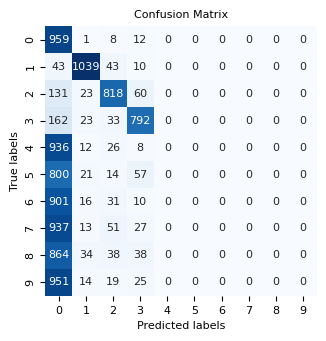

Precision: 0.26774304438626223
Recall: 0.3608
F1 Score: 0.28368875144629674
True Positives for Each Class: [ 959 1039  818  792    0    0    0    0    0    0]
              precision    recall  f1-score   support

           0       0.14      0.98      0.25       980
           1       0.87      0.92      0.89      1135
           2       0.76      0.79      0.77      1032
           3       0.76      0.78      0.77      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.36     10000
   macro avg       0.25      0.35      0.27     10000
weighted avg       0.27      0.36      0.28     10000

[16, 24, 12, 28, 37, 37, 20]


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [37]:
start_time = time.time()
forget_class = 4
with open('forget_5_mnistdt.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()
    
node_removal_counter = 0
for idx,line in enumerate(tree_ifel_code):
    if f'label_class= {forget_class}' in line:
        tree_ifel_code[idx] = ''
        tree_ifel_code[idx-1] = ''
        node_removal_counter = node_removal_counter+1
node_removal.append(node_removal_counter)
        

with open(f'forget_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(tree_ifel_code)
    f.close()

end_time = time.time()
execution_time = end_time - start_time
print("Unlearning time:", execution_time, "seconds")

start_time = time.time()


from forget_4_mnistdt import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))


import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))

end_time = time.time()

execution_time = end_time - start_time
print("Inference per sample after unlearn:", execution_time/len(X_test), "seconds")

cm = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(3.5, 3.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), 
            yticklabels=range(10), annot_kws={"size": 8}, cbar=False )
plt.xlabel('Predicted labels', fontsize=8)
plt.ylabel('True labels', fontsize=8)
plt.title('Confusion Matrix', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.savefig(f'confusion_matrix_forget_{forget_class}.pdf')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)
print(node_removal)

#### Relearn method: class 0 to 3

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
start_time = time.time()

X_train_filtered = X_train[y_train <forget_class]
y_train_filtered = y_train[y_train <forget_class]
X_test_filtered = X_test[y_test <forget_class]
y_test_filtered = y_test[y_test <forget_class]

# Create Decision Tree Classifier
retrain_clf = DecisionTreeClassifier(max_depth=8)

# Train the classifier
retrain_clf.fit(X_train_filtered, y_train_filtered)

end_time = time.time()
execution_time = end_time - start_time
print("Re-learning time:", execution_time, "seconds")

# Predict on the test set
y_pred = retrain_clf.predict(X_test_filtered)

# Calculate accuracy score
accuracy = accuracy_score(y_test_filtered, y_pred)
print("Accuracy:", accuracy)

Re-learning time: 1.9163122177124023 seconds
Accuracy: 0.958624007697859


##### Run this cell twice.

In [40]:
%%capture cap --no-stderr

from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += ":\n"
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"    label_class= {class_names[l]} #(proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += ['  ' + rule]
        
    return rules

cols = range(784)
features = [f'feature_num[{i}]' for i in cols]
class_names = [str(i) for i in dt_clf.classes_]
tree_ = retrain_clf.tree_
feature_name = [
    features[i] if i != _tree.TREE_UNDEFINED else "undefined!"
    for i in tree_.feature
]
print ("def decision_tree_inference({}):".format('feature_num'))
print('  label_class= None')
            
rules = get_rules(retrain_clf, features, class_names)
for r in rules:
    print(r)
print('  return label_class')
    
with open(f'relearn_without{forget_class}.py', 'w') as f:
    f.write(cap.stdout)

In [41]:
start_time = time.time()
from relearn_without4 import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = np.random.randint(0,forget_class)
        
print(accuracy_score(y_test, y_test_pred_tree))

end_time = time.time()

execution_time = end_time - start_time
print("Inference time per sample after relearn:", execution_time/len(X_test), "seconds")

0.3985
Inference time per sample after relearn: 0.0003139981031417847 seconds


#### Forgetting class 3

Unlearning time: 0.0025784969329833984 seconds
0.2828
Inference per sample after unlearn: 0.00024488644599914553 seconds


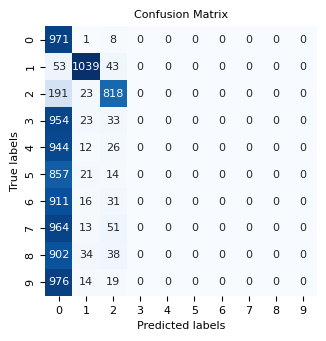

Precision: 0.18901426712159464
Recall: 0.2828
F1 Score: 0.20295197603292153
True Positives for Each Class: [ 971 1039  818    0    0    0    0    0    0    0]
              precision    recall  f1-score   support

           0       0.13      0.99      0.22       980
           1       0.87      0.92      0.89      1135
           2       0.76      0.79      0.77      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.28     10000
   macro avg       0.18      0.27      0.19     10000
weighted avg       0.19      0.28      0.20     10000

[16, 24, 12, 28, 37, 37, 20, 33]


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [42]:
start_time = time.time()

forget_class = 3
with open('forget_4_mnistdt.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()
    
node_removal_counter = 0
for idx,line in enumerate(tree_ifel_code):
    if f'label_class= {forget_class}' in line:
        tree_ifel_code[idx] = ''
        tree_ifel_code[idx-1] = ''
        node_removal_counter = node_removal_counter+1
node_removal.append(node_removal_counter)
        

with open(f'forget_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(tree_ifel_code)
    f.close()

end_time = time.time()
execution_time = end_time - start_time
print("Unlearning time:", execution_time, "seconds")

start_time = time.time()
from forget_3_mnistdt import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))


import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))


end_time = time.time()

execution_time = end_time - start_time
print("Inference per sample after unlearn:", execution_time/len(X_test), "seconds")

cm = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(3.5, 3.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), 
            yticklabels=range(10), annot_kws={"size": 8}, cbar=False )
plt.xlabel('Predicted labels', fontsize=8)
plt.ylabel('True labels', fontsize=8)
plt.title('Confusion Matrix', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.savefig(f'confusion_matrix_forget_{forget_class}.pdf')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)
print(node_removal)

#### Relearn method: from class 0 to 2

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
start_time = time.time()

X_train_filtered = X_train[y_train <forget_class]
y_train_filtered = y_train[y_train <forget_class]
X_test_filtered = X_test[y_test <forget_class]
y_test_filtered = y_test[y_test <forget_class]

# Create Decision Tree Classifier
retrain_clf = DecisionTreeClassifier(max_depth=8)

# Train the classifier
retrain_clf.fit(X_train_filtered, y_train_filtered)

end_time = time.time()
execution_time = end_time - start_time
print("Re-learning time:", execution_time, "seconds")

# Predict on the test set
y_pred = retrain_clf.predict(X_test_filtered)

# Calculate accuracy score
accuracy = accuracy_score(y_test_filtered, y_pred)
print("Accuracy:", accuracy)

Re-learning time: 1.137589931488037 seconds
Accuracy: 0.9774388306323483


##### Run this cell twice.

In [45]:
%%capture cap --no-stderr

from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += ":\n"
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"    label_class= {class_names[l]} #(proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += ['  ' + rule]
        
    return rules

cols = range(784)
features = [f'feature_num[{i}]' for i in cols]
class_names = [str(i) for i in dt_clf.classes_]
tree_ = retrain_clf.tree_
feature_name = [
    features[i] if i != _tree.TREE_UNDEFINED else "undefined!"
    for i in tree_.feature
]
print ("def decision_tree_inference({}):".format('feature_num'))
print('  label_class= None')
            
rules = get_rules(retrain_clf, features, class_names)
for r in rules:
    print(r)
print('  return label_class')
    
with open(f'relearn_without{forget_class}.py', 'w') as f:
    f.write(cap.stdout)

In [46]:
start_time = time.time()
from relearn_without3 import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = np.random.randint(0,forget_class)
        
print(accuracy_score(y_test, y_test_pred_tree))

end_time = time.time()

execution_time = end_time - start_time
print("Inference time per sample after relearn:", execution_time/len(X_test), "seconds")

0.3076
Inference time per sample after relearn: 0.00023699355125427247 seconds


#### Forgetting class 2

Unlearning time: 0.003753662109375 seconds
0.2018
Inference per sample after unlearn: 7.025792598724366e-05 seconds


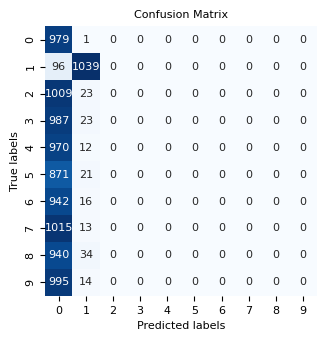

Precision: 0.10949829907810224
Recall: 0.2018
F1 Score: 0.12079305780491391
True Positives for Each Class: [ 979 1039    0    0    0    0    0    0    0    0]
              precision    recall  f1-score   support

           0       0.11      1.00      0.20       980
           1       0.87      0.92      0.89      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.20     10000
   macro avg       0.10      0.19      0.11     10000
weighted avg       0.11      0.20      0.12     10000

[16, 24, 12, 28, 37, 37, 20, 33, 36]


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [47]:
start_time = time.time()

forget_class = 2
with open('forget_3_mnistdt.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()
    
node_removal_counter = 0
for idx,line in enumerate(tree_ifel_code):
    if f'label_class= {forget_class}' in line:
        tree_ifel_code[idx] = ''
        tree_ifel_code[idx-1] = ''
        node_removal_counter = node_removal_counter+1
node_removal.append(node_removal_counter)
        

with open(f'forget_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(tree_ifel_code)
    f.close()

end_time = time.time()
execution_time = end_time - start_time
print("Unlearning time:", execution_time, "seconds")

start_time = time.time()

from forget_2_mnistdt import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))


import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))

end_time = time.time()

execution_time = end_time - start_time
print("Inference per sample after unlearn:", execution_time/len(X_test), "seconds")

cm = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(3.5, 3.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), 
            yticklabels=range(10), annot_kws={"size": 8}, cbar=False )
plt.xlabel('Predicted labels', fontsize=8)
plt.ylabel('True labels', fontsize=8)
plt.title('Confusion Matrix', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.savefig(f'confusion_matrix_forget_{forget_class}.pdf')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)
print(node_removal)

#### Relearn method: from class 0 to 1

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
start_time = time.time()

X_train_filtered = X_train[y_train <forget_class]
y_train_filtered = y_train[y_train <forget_class]
X_test_filtered = X_test[y_test <forget_class]
y_test_filtered = y_test[y_test <forget_class]

# Create Decision Tree Classifier
retrain_clf = DecisionTreeClassifier(max_depth=8)

# Train the classifier
retrain_clf.fit(X_train_filtered, y_train_filtered)

end_time = time.time()
execution_time = end_time - start_time
print("Re-learning time:", execution_time, "seconds")

# Predict on the test set
y_pred = retrain_clf.predict(X_test_filtered)

# Calculate accuracy score
accuracy = accuracy_score(y_test_filtered, y_pred)
print("Accuracy:", accuracy)

Re-learning time: 0.9464859962463379 seconds
Accuracy: 0.9971631205673759


##### Run this cell twice.

In [50]:
%%capture cap --no-stderr

from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += ":\n"
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"    label_class= {class_names[l]} #(proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += ['  ' + rule]
        
    return rules

cols = range(784)
features = [f'feature_num[{i}]' for i in cols]
class_names = [str(i) for i in dt_clf.classes_]
tree_ = retrain_clf.tree_
feature_name = [
    features[i] if i != _tree.TREE_UNDEFINED else "undefined!"
    for i in tree_.feature
]
print ("def decision_tree_inference({}):".format('feature_num'))
print('  label_class= None')
            
rules = get_rules(retrain_clf, features, class_names)
for r in rules:
    print(r)
print('  return label_class')
    
with open(f'relearn_without{forget_class}.py', 'w') as f:
    f.write(cap.stdout)

In [51]:
start_time = time.time()
from relearn_without2 import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = np.random.randint(0,forget_class)
        
print(accuracy_score(y_test, y_test_pred_tree))

end_time = time.time()

execution_time = end_time - start_time
print("Inference time per sample after relearn:", execution_time/len(X_test), "seconds")

0.2109
Inference time per sample after relearn: 7.599160671234131e-05 seconds


### Plottings

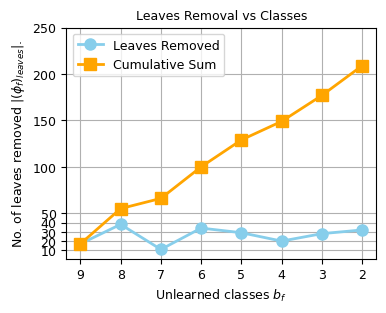

In [101]:
# Data
node_removal = [17, 38, 11, 34, 29, 20, 28, 32]
classes = [9, 8, 7, 6, 5, 4, 3, 2]

cumulative_sum = [sum(node_removal[:i+1]) for i in range(len(node_removal))]

# Plot
plt.figure(figsize=(4, 3))
# Plot node_removal
plt.plot(range(1, len(classes) + 1), node_removal, marker='o', color='skyblue', linewidth=2, markersize=8, label='Leaves Removed')

# Plot cumulative sum
plt.plot(range(1, len(classes) + 1), cumulative_sum, marker='s', color='orange', linewidth=2, markersize=8, label='Cumulative Sum')
plt.xlabel('Unlearned classes $b_f$', fontsize=9)
plt.ylabel('No. of leaves removed $|(\phi_f)_{leaves}|$.', fontsize=9)
plt.title('Leaves Removal vs Classes', fontsize=9)
plt.xticks(range(1, len(classes) + 1), classes, fontsize=9)
plt.yticks([10,20,30,40,50, 100, 150, 200, 250], fontsize=9)
plt.grid(True)
plt.legend(fontsize=9)
plt.savefig('leaves_removal.pdf', bbox_inches='tight')
plt.show()

#### Again checking the nodes that were used in classes from `2 to 9` but not in `0 and 1`.

In [82]:
learn_nodes = set()
learn_nodes.update(intermediate_nodes_per_class[0])
learn_nodes.update(intermediate_nodes_per_class[1])
for forget_class in [2,3,4,5,6,7,8,9]: 
    print(len(intermediate_nodes - learn_nodes))
    learn_nodes.update(intermediate_nodes_per_class[forget_class])

19
7
1
0
0
0
0
0


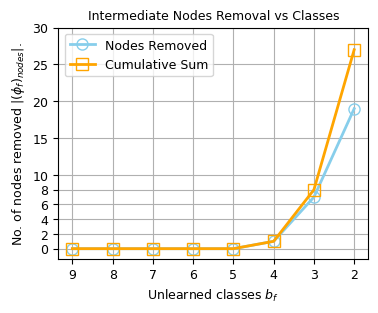

In [98]:
# Data
node_removal = [0,0,0,0,0,1,7,19]
classes = [9, 8, 7, 6, 5, 4, 3, 2]

cumulative_sum = [sum(node_removal[:i+1]) for i in range(len(node_removal))]

# Plot
plt.figure(figsize=(4, 3))
# Plot node_removal
plt.plot(range(1, len(classes) + 1), node_removal, marker='o', color='skyblue', linewidth=2, markersize=8, fillstyle='none', label='Nodes Removed')

# Plot cumulative sum
plt.plot(range(1, len(classes) + 1), cumulative_sum, marker='s', color='orange', linewidth=2, markersize=8, fillstyle='none', label='Cumulative Sum')
plt.xlabel('Unlearned classes $b_f$', fontsize=9)
plt.ylabel('No. of nodes removed $|(\phi_f)_{nodes}|$.', fontsize=9)
plt.title('Intermediate Nodes Removal vs Classes', fontsize=9)
plt.xticks(range(1, len(classes) + 1), classes, fontsize=9)
plt.yticks([0,2,4,6,8,10,15,20,25,30], fontsize=9)
plt.grid(True)
plt.legend(fontsize=9)
plt.savefig('nodes_removal.pdf', bbox_inches='tight')
plt.show()

# Now relearning the forgetted label.

#### Learning again the label 2. Use the dataset for class 0 as well along with 2.

In [48]:
relearn_class = 2

# Filter dataset to include only classes 0 and 2
X_02_train = X_train[(y_train == 0) | (y_train == 2)]
y_02_train = y_train[(y_train == 0) | (y_train == 2)]

X_02_test = X_test[(y_test == 0) | (y_test == 2)]
y_02_test = y_test[(y_test == 0) | (y_test == 2)]

# Train a decision tree classifier
clf02_dt = tree.DecisionTreeClassifier(max_depth=8)
clf02_dt.fit(X_02_train, y_02_train)

# Make predictions
y_pred = clf02_dt.predict(X_02_test)

# Evaluate accuracy
accuracy = accuracy_score(y_02_test, y_pred)
print("Accuracy:", accuracy)

class_names = ['0','2']
#Now extract rules
rules = get_rules(clf02_dt, features, class_names)

#Extract rules for class 2
class_2rules = []
for idx,line in enumerate(rules):
    if f'label_class= {relearn_class}' in line:
        class_2rules.append(line)
        
#Create a python file by appending these rules in model that has learned classes 0,1
with open('forget_3_mnistdt.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()
        
with open(f'relearn_{relearn_class}_mnistdt.py', 'w') as f:
    f.writelines(tree_ifel_code[:-1])
    f.writelines('\n')
    f.writelines('\n'.join(class_2rules))
    f.writelines('\n'+tree_ifel_code[-1])
    f.close()

Accuracy: 0.9821073558648111


0.1982


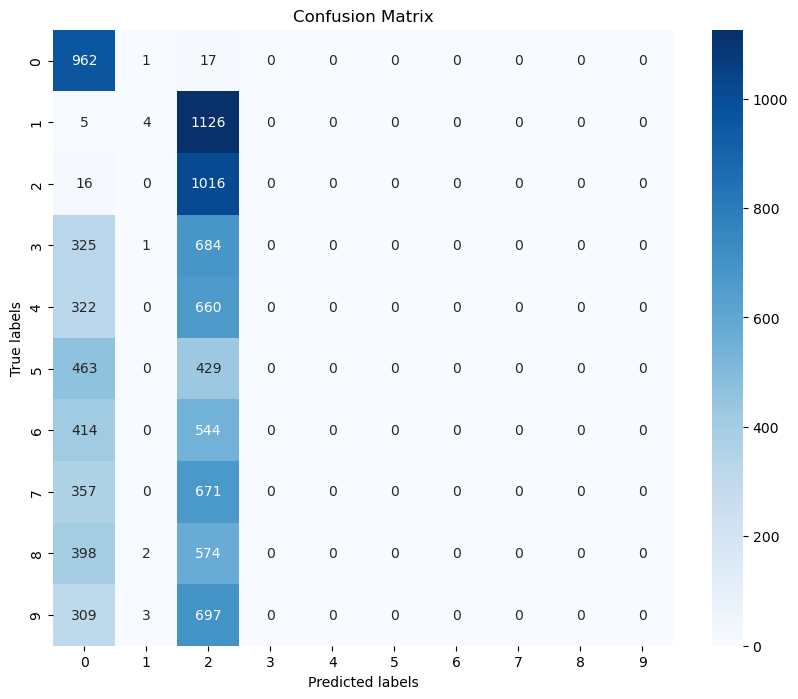

Precision: 0.08401022736762803
Recall: 0.1982
F1 Score: 0.07037118858023393
True Positives for Each Class: [ 962    4 1016    0    0    0    0    0    0    0]
              precision    recall  f1-score   support

           0       0.27      0.98      0.42       980
           1       0.36      0.00      0.01      1135
           2       0.16      0.98      0.27      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.20     10000
   macro avg       0.08      0.20      0.07     10000
weighted avg       0.08      0.20      0.07     10000



C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [54]:
import relearn_2_mnistdt 
from relearn_2_mnistdt import decision_tree_inference
import importlib
importlib.reload(relearn_2_mnistdt)
from relearn_2_mnistdt import decision_tree_inference

y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))


import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))

cm = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)

### Hmm, the outcome is, the model forget the learning for class 1 because this calss has not been used while learning class 2. Additional investigation is needed.

#### Ideally the solution are as follows:
1. Generate a sklearn model from the extracted rules. 
2. Now use that model to progressively learn class 2 without forgetting the already learned classes (0,1).

Such a mechanism is available in the neural network model but not known about the decision tree. Further, there is no mechansim to build sklearn model from the extracted rules.